# Topology optimization of a waveguide crossing

In this example, we will walk you through performing a simple inverse design optimization of a 3D waveguide crossing.

In this example, we'll be using a pixelated material grid to define the design region. However, one could also use shape parameterization to solve the same problem. You can see how this is done for a waveguide bend [here](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd8WaveguideBend/).

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

Before using Tidy3D, you must first [sign up](https://tidy3d.simulation.cloud/signup) for a user account. See [this link](https://docs.flexcompute.com/projects/tidy3d/en/latest/install.html) for installation instructions.

In this tutorial we are demonstrating the smoothed projection by Alec Hammond et al. from the paper "Unifying and accelerating level-set and density-based topology optimization by subpixel-smoothed projection". You can find the article [here](https://opg.optica.org/oe/fulltext.cfm?uri=oe-33-16-33620).

<img src="img/adjoint_25.png" width=400 alt="Schematic of the inverse designed waveguide crossing">


## Setup

First we import the packages we need and also define some of the global parameters that define our problem.

> Important note: we use `autograd.numpy` instead of regular `numpy`, this allows `numpy` functions to be differentiable. If one forgets this step, the error may be a bit opaque, just a heads up.

In [10]:
import math

import autograd
import autograd.numpy as np
import matplotlib.pylab as plt
import optax
import tidy3d as td
import tidy3d.web as web
from tidy3d import config
from tidy3d.plugins.autograd.invdes.filters import ConicFilter
from tidy3d.plugins.autograd.invdes.parametrizations import initialize_params_from_simulation
from tidy3d.plugins.autograd.invdes.projections import smoothed_projection
from tidy3d.plugins.autograd.invdes.symmetries import symmetrize_diagonal, symmetrize_mirror

config.simulation.use_local_subpixel = False

In [11]:
# spectral parameters
wvl0 = 1.0
freq0 = td.C_0 / wvl0

# geometric parameters
eps_mat = 4.0
wg_width = 0.5 * wvl0
wg_length = 1.0 * wvl0
design_size = 3 * wvl0
thick = 0.2 * wvl0

# resolution
min_steps_per_wvl = 50
pixel_size = wvl0 / (min_steps_per_wvl * np.sqrt(eps_mat))
print(f"{pixel_size=}")

radius = 0.150
floor_radius = math.floor(radius / pixel_size)
discrete_radius = floor_radius if floor_radius % 2 == 1 else floor_radius + 1
discrete_num_pixels = round(design_size / pixel_size)
print(f"{floor_radius=}")
print(f"{discrete_radius=}")
print(f"{discrete_num_pixels=}")

pixel_size=np.float64(0.01)
floor_radius=15
discrete_radius=15
discrete_num_pixels=300


Next, we will define all the components that make up our "base" simulation. This simulation defines the static portion of our optimization, which doesn't change over the iterations. Since our simulation scene has a symmetry in the y and z-axis, we will include the correspoding symmetry flag in the Simulation definition. This makes the simulation four times as fast and also reduces cost by a factor of four. For a tutorial on symmetries in simulations check out this notebook [here](https://www.flexcompute.com/tidy3d/examples/notebooks/Symmetry/). 

For now, we'll include a definition of the design region geometry, just to have that on hand later, but will not include a design region in the base simulation as we'll add it later.

In [12]:
waveguide_long_horizontal = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(td.inf, wg_width, thick),
    ),
    medium=td.Medium(permittivity=eps_mat),
)

waveguide_long_vertical = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(wg_width, td.inf, thick),
    ),
    medium=td.Medium(permittivity=eps_mat),
)

design_region_geometry = td.Box(
    center=(0, 0, 0),
    size=(design_size, design_size, thick),
)

mode_source_horizontal = td.ModeSource(
    center=(-design_size / 2.0 - wg_length + wvl0 / 3, 0, 0),
    size=(0, wg_width * 3, td.inf),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=freq0 / 20,
    ),
    mode_index=0,
    direction="+",
)

mode_monitor = td.ModeMonitor(
    center=(-mode_source_horizontal.center[0] + 0.2, 0, 0),
    size=(0, mode_source_horizontal.size[1], td.inf),
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=1),
    name="mode",
)

mode_monitor_multiple_wl = td.ModeMonitor(
    center=(-mode_source_horizontal.center[0] + 0.2, 0, 0),
    size=(0, mode_source_horizontal.size[1], td.inf),
    freqs=td.C_0 / np.linspace(wvl0 * 1.2, wvl0 / 1.2, 101),
    mode_spec=td.ModeSpec(num_modes=1),
    name="mode_multiple_wl",
)

field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

sim_base = td.Simulation(
    size=(2 * wg_length + design_size, 2 * wg_length + design_size, thick + 2 * wvl0),
    symmetry=(0, -1, 1),
    run_time=100 / mode_source_horizontal.source_time.fwidth,
    structures=[
        waveguide_long_horizontal,
        waveguide_long_vertical,
    ],
    sources=[mode_source_horizontal],
    monitors=[mode_monitor],
    boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True),
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl,
        override_structures=[
            td.MeshOverrideStructure(geometry=design_region_geometry, dl=3 * [pixel_size])
        ],
    ),
)

Let's visualize the base simulations to verify that they look correct. The shaded region indicates that we are using a symmetry condition to determine the fields in this region, such that this region does not need to be simulated.

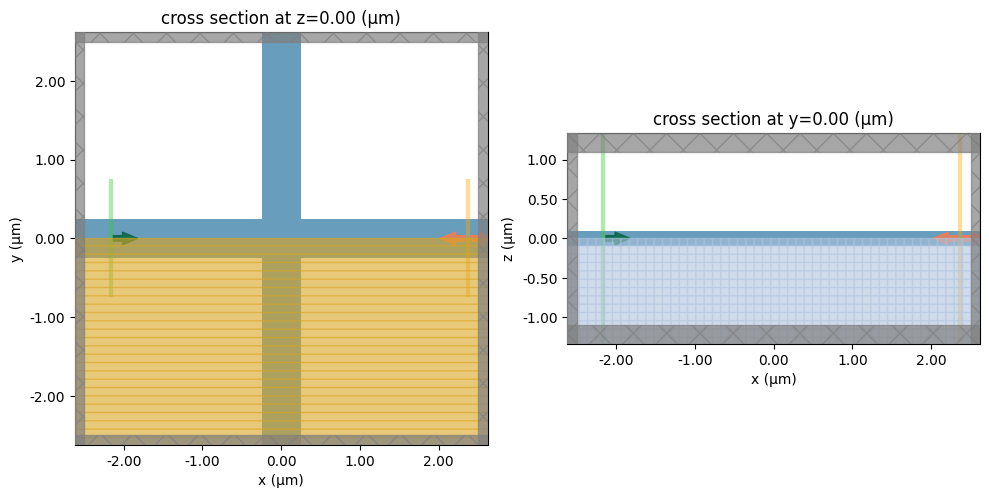

In [13]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 7), tight_layout=True)
sim_base.plot(z=0, ax=ax0)
sim_base.plot(y=0, ax=ax1)
plt.show()

## Define Parameterization

Next, we will define how our design region is constructed as a function of our optimization parameters.

We will define a structure containing a grid of permittivity values defined by an array. Since we have a symmetric waveguide crossing, we only need to optimize 1/8 of the design volume. Therefore, we use some symmetry helper functions to constrain our device to these symmetries.

We will convolve our optimization parameters with a conic filter to smooth the features over a given `radius`. Then we will add a smoothed projection function (see the paper [here](https://arxiv.org/pdf/2503.20189) for full details). The advantage of this projection is that we can work with fully binarized structures in our simulation. Since we assume that our topology should not change during optimization, we can use a value of $\beta = \infty$ during the whole simulation process, which completely binarizes the design except for a small boundary at the interface change. If we want to change the topology during optimization, we could also add a scheduling for the beta parameter, increasing it step-wise towards $\beta = \infty$. However, for our example this is not necessary.

For more details on the parameterization process, we highly recommend [our short tutorial](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/Inverse-Design-in-Photonics-Lecture-4-Fabrication-Constraints/), which explains the process in more detail.

In [14]:
def get_density(params: np.ndarray) -> np.ndarray:
    """Get the density of the material in the design region as a function of optimization parameters."""
    arr = symmetrize_mirror(params, axis=(0, 1))
    arr = symmetrize_diagonal(arr)
    filter = ConicFilter(kernel_size=discrete_radius)
    arr_filtered = filter(arr)

    arr_projected = smoothed_projection(arr_filtered, beta=np.inf, eta=0.5)
    return arr_projected


def get_design_region(params: np.ndarray) -> td.Structure:
    """Get design region structure as a function of optimization parameters."""
    density = get_density(params)
    eps_data = 1 + (eps_mat - 1) * density[:, :, None]
    return td.Structure.from_permittivity_array(eps_data=eps_data, geometry=design_region_geometry)

Next, it is very convenient to wrap this in a function that returns an updated copy of the base simulation with the design region added. We'll be calling this in our objective function. We'll also add some logic to exclude field monitors if they aren't needed, for example during the optimization.

In [15]:
def get_sim(params: np.ndarray, with_fld_mnt: bool = False) -> td.Simulation:
    """Get simulation as a function of optimization parameters."""
    design_region = get_design_region(params)
    sim = sim_base.updated_copy(structures=sim_base.structures + (design_region,))
    if with_fld_mnt:
        sim = sim.updated_copy(
            monitors=sim_base.monitors + (field_monitor, mode_monitor_multiple_wl)
        )
    return sim

To start with the optimization, we need some initial parameters that can be optimized. These initial parameters could be chosen randomly, but the optimization will run faster and need less iterations to converge if we start from a design that is already performing a little better than random. In this case it is very easy to come up with such a design: We just initialize our parameters such that they represent the waveguides of the base simulations, which we defined above. In other words, we initialize our parameters such that they represent a naive waveguide crossing where the two waveguides simply overlap.

However, it can be a bit difficult to work out how the parameters should look to form this structure in the simulation since there is a smoothing and projection involved. Luckily, we have a helper function, which automatically determines how the parameters should look to represent the base simulation. This helper function takes the desired simulation as input and optimizes our initial parameters to reflect this simulation as best as possible.

In [16]:
rng = np.random.default_rng(seed=42)
params0 = rng.random(size=(discrete_num_pixels, discrete_num_pixels))
params0 = initialize_params_from_simulation(
    sim=sim_base,
    param_to_structure=get_design_region,
    params0=params0,
    maxiter=1000,
)

Let's take a look at the resulting parameters which form the initial design. The raw parameters look noisy, but due to the conic filter and smoothed projection the parameters used in simulations form the initial cross design.

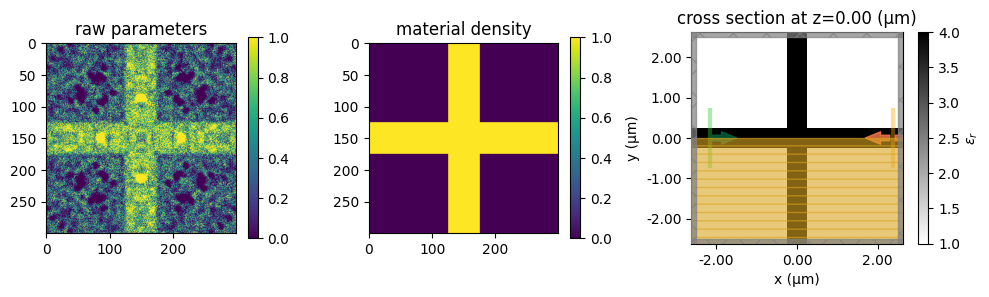

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 7), tight_layout=True)

im0 = ax0.imshow(params0)
ax0.set_title("raw parameters")
fig.colorbar(im0, ax=ax0, shrink=0.3)

density0 = get_density(params0)
im1 = ax1.imshow(density0)
ax1.set_title("material density")
fig.colorbar(im1, ax=ax1, shrink=0.3)


temporary_sim = get_sim(params0)
temporary_sim.plot_eps(z=0, ax=ax2)

plt.show()

We can also run a quick simulation with a field monitor added to verify how poorly the initial device is transmitting. This gives us lots of room to improve things through optimization!

In [18]:
sim0 = get_sim(params0, with_fld_mnt=True)
sim_data_init = web.run(sim0, task_name="initial_waveguide_crossing")

08:38:56 CET Created task 'initial_waveguide_crossing' with resource_id         
             'fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=886429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=94583;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\taskId]8;;\]8;id=886429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\=]8;;\]8;id=790837;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\fdve]8;;\]8;id=886429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\-3b75a6f9-c99]8;;\
             ]8;id=886429;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\1-4806-9ea5-a7c0e9f44e21']8;;\.

             Task folder: ]8;id=457301;https://tidy3d.simulation.cloud/folders/folder-b09a5d67-f90e-4deb-9d9b-a702c3884aec\'default']8;;\.

Output()

08:39:04 CET Estimated FlexCredit cost: 1.119. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

08:39:06 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

08:39:15 CET starting up solver

08:39:16 CET running solver

Output()

08:39:27 CET early shutoff detected at 4%, exiting.

08:39:28 CET status = postprocess

Output()

08:39:34 CET status = success

08:39:36 CET View simulation result at                                          
             ]8;id=348570;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=137207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\taskId]8;;\]8;id=348570;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\=]8;;\]8;id=751434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\fdve]8;;\]8;id=348570;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\-3b75a6f9-c99]8;;\
             ]8;id=348570;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3b75a6f9-c991-4806-9ea5-a7c0e9f44e21\1-4806-9ea5-a7c0e9f44e21']8;;\.

Output()

08:39:39 CET Loading simulation from simulation_data.hdf5

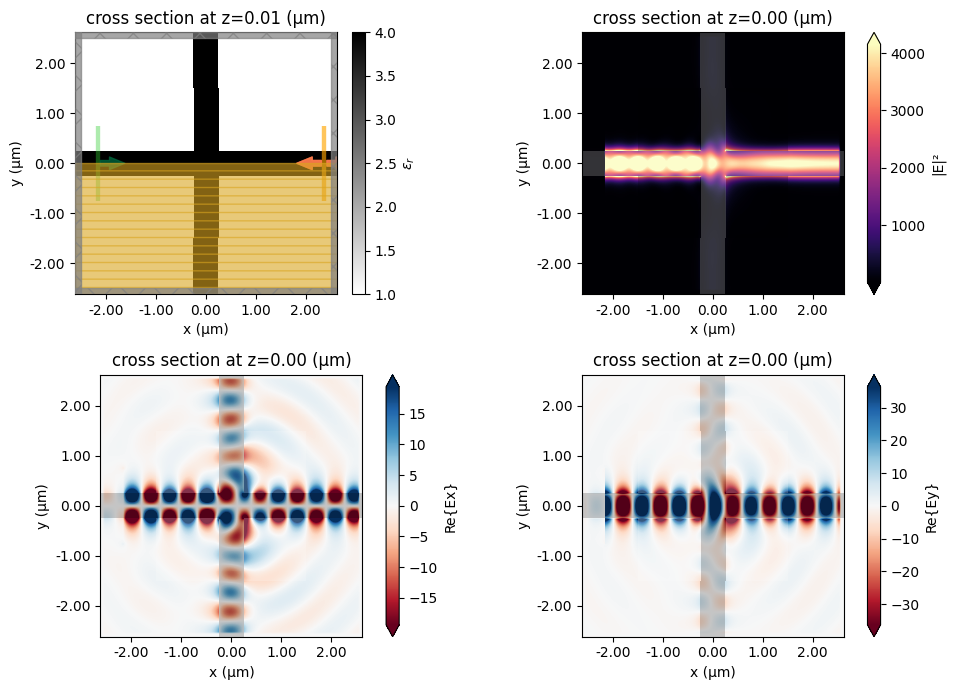

In [19]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)
sim0.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_init.plot_field("field", "E", "abs^2", z=0, ax=ax1)
ax2 = sim_data_init.plot_field("field", "Ex", z=0, ax=ax2)
ax3 = sim_data_init.plot_field("field", "Ey", z=0, ax=ax3)

## Define Objective Function

The next step is to define the metric that we want to optimize, or our "figure of merit". We will first write a function to compute the transmission (between 0-1) of the output mode given the simulation data. 

In [20]:
def get_transmission_from_data(data):
    mode_amps = data["mode"].amps.sel(direction="+").values
    energy = np.sum(np.abs(mode_amps) ** 2)
    return energy

Initial transmission at center wavelength: 0.7760829713128199


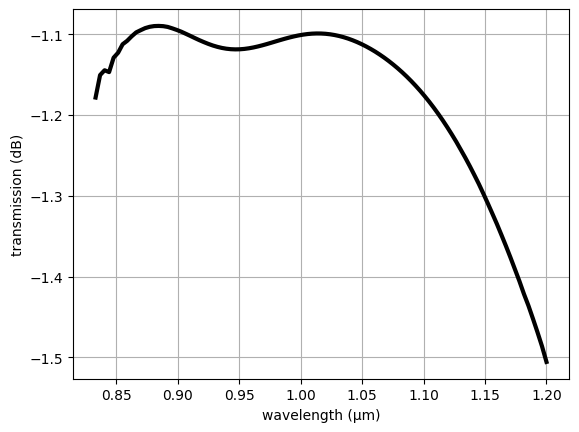

In [21]:
print(
    f"Initial transmission at center wavelength: {get_transmission_from_data(sim_data_init).item()}"
)

transmission_init = abs(sim_data_init["mode_multiple_wl"].amps.sel(direction="+")) ** 2
transmission_init_db = 10 * np.log10(transmission_init)
wavelengths = td.C_0 / transmission_init.f

plt.plot(wavelengths, transmission_init_db, c="black", linewidth=3)
plt.xlabel("wavelength (μm)")
plt.ylabel("transmission (dB)")
plt.grid()
plt.show()

Next we can put everything together into a single objective function.

In [22]:
def objective(params: np.ndarray) -> float:
    """Objective function."""
    sim = get_sim(params)
    data = web.run(sim, task_name="crossing", verbose=False)
    transmission = get_transmission_from_data(data)
    return transmission

## Optimization

Getting the gradient of the `objective` function is easy using `autograd`. Calling `g = autograd.value_and_grad(f)` returns a function `g` that when evaluated returns the objective function value and its gradient.

We use this as it's more efficient and we don't have to re-compute the objective during the gradient calculation step if we want to store the value too.

Let's construct this function now and have it ready to use in the main optimization loop.

In [23]:
val_grad_fn = autograd.value_and_grad(objective)

Next we will run the optimizer, we first make a cell to define the parameters and some convenience functions and objects to store our history.

In [24]:
# hyperparameters
num_steps = 25
learning_rate = 0.1

# initialize Adam optimizer with starting parameters
params = np.copy(params0)

optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)


# store history
objective_history = []
param_history = [params]

And then we can iteratively update our optimizer and parameters using the gradient calculated in each step.

We'll throw in a quick visualization of our device material density just to keep an eye on things as the optimization progresses.

> Note: the following optimization loop will take about half an hour. To run fewer iterations, just change `num_steps` to something smaller above.

step = 1


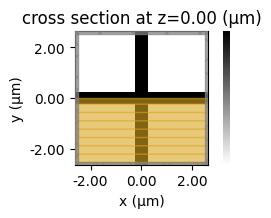

	J = 7.7608e-01
	grad_norm = 2.3951e-03
step = 2


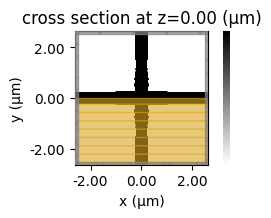

	J = 7.8869e-01
	grad_norm = 5.1135e-03
step = 3


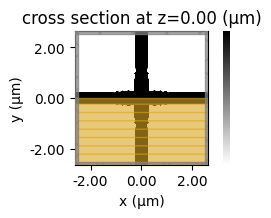

	J = 8.0117e-01
	grad_norm = 4.1316e-03
step = 4


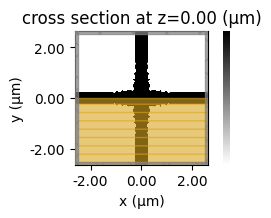

	J = 8.1040e-01
	grad_norm = 5.3284e-03
step = 5


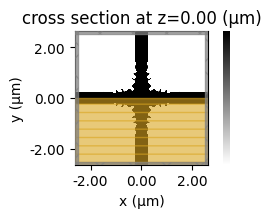

	J = 8.2853e-01
	grad_norm = 6.5882e-03
step = 6


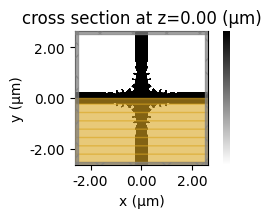

	J = 8.5414e-01
	grad_norm = 7.3802e-03
step = 7


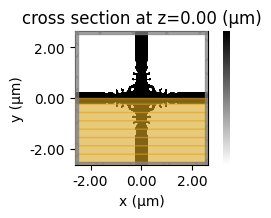

	J = 8.5461e-01
	grad_norm = 1.2117e-02
step = 8


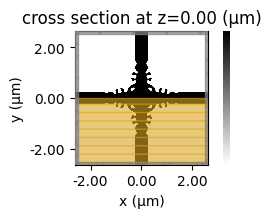

	J = 8.7582e-01
	grad_norm = 9.5314e-03
step = 9


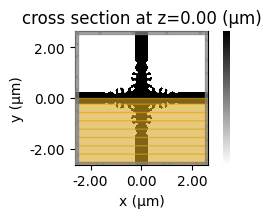

	J = 8.9434e-01
	grad_norm = 4.4150e-03
step = 10


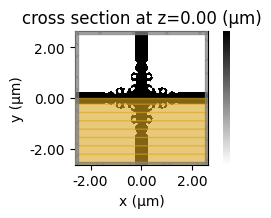

	J = 9.0213e-01
	grad_norm = 1.1615e-02
step = 11


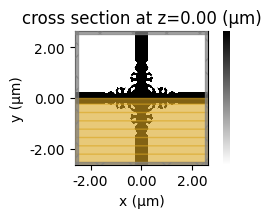

	J = 9.1098e-01
	grad_norm = 4.4071e-03
step = 12


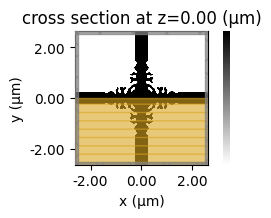

	J = 9.1467e-01
	grad_norm = 4.4776e-03
step = 13


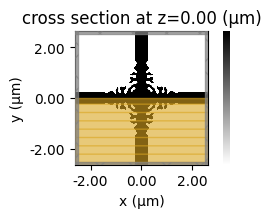

	J = 9.2012e-01
	grad_norm = 3.8453e-03
step = 14


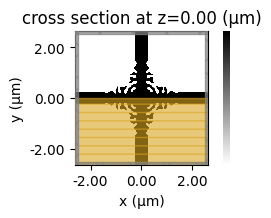

	J = 9.2644e-01
	grad_norm = 3.0016e-03
step = 15


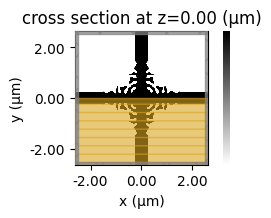

	J = 9.3196e-01
	grad_norm = 2.8073e-03
step = 16


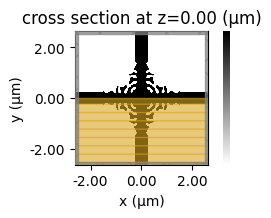

	J = 9.3698e-01
	grad_norm = 2.4274e-03
step = 17


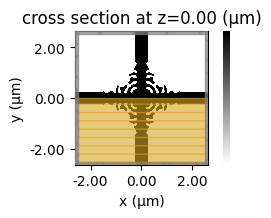

	J = 9.4137e-01
	grad_norm = 2.4483e-03
step = 18


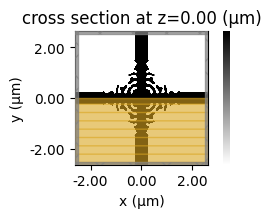

	J = 9.4520e-01
	grad_norm = 2.5181e-03
step = 19


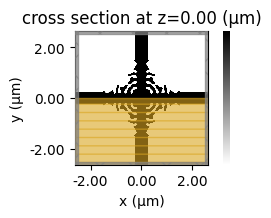

	J = 9.4981e-01
	grad_norm = 2.8468e-03
step = 20


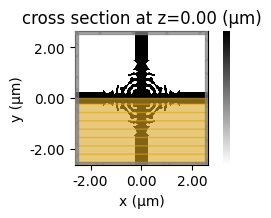

	J = 9.5480e-01
	grad_norm = 3.0946e-03
step = 21


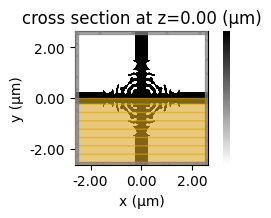

	J = 9.5986e-01
	grad_norm = 2.7566e-03
step = 22


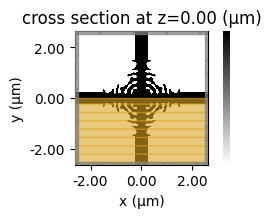

	J = 9.6391e-01
	grad_norm = 2.8375e-03
step = 23


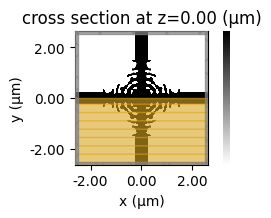

	J = 9.6573e-01
	grad_norm = 2.0951e-03
step = 24


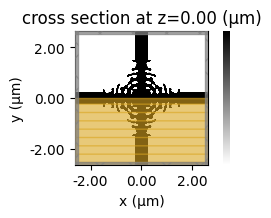

	J = 9.6667e-01
	grad_norm = 2.3318e-03
step = 25


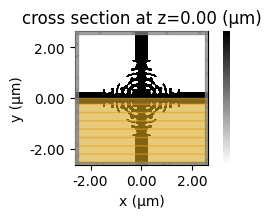

	J = 9.6852e-01
	grad_norm = 2.0418e-03
CPU times: user 1min 49s, sys: 1.71 s, total: 1min 50s
Wall time: 44min 35s


In [25]:
%%time
for i in range(num_steps):
    print(f"step = {i + 1}")

    sim_i = get_sim(params)
    _, ax = plt.subplots(figsize=(2, 2))
    sim_i.plot_eps(z=0, ax=ax, monitor_alpha=0.0, source_alpha=0.0)
    plt.axis("off")
    plt.show()

    # re-compute gradient and current objective function value
    value, gradient = val_grad_fn(params)

    # outputs
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the parameters using the gradient (-1 sign to maximize)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)

    # we need to constrain the values between (0,1)
    np.clip(params, 0, 1, out=params)

    # save history
    objective_history.append(value)
    param_history.append(params)

## Analysis

Now is the fun part! We get to take a look at our optimization results.

We first plot the objective function values over the course of optimization, which should show a steady increase. Since the curve has not yet leveled off completely, we can conclude that we could run the optimization for longer to achieve even more improvements.

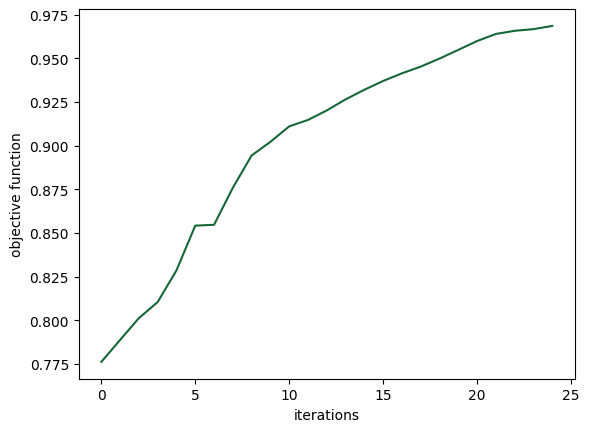

In [26]:
plt.plot(objective_history)
plt.xlabel("iterations")
plt.ylabel("objective function")
plt.show()

Next, we can look at the performance of our optimized device, we first construct it using the final parameter values and then take a look at the design.

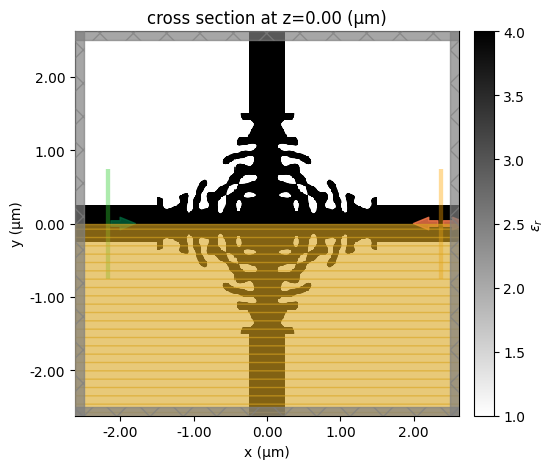

In [27]:
params_final = param_history[-1]
sim_final = get_sim(params_final)
sim_final.plot_eps(z=0)
plt.show()

This optimized device seems to have some very intricate structures, which might be difficult to fabricate. This can be recifified by adding an additional loss term penalizing small structures. You can take a look at [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd18TopologyBend/) on how this may be done.

Let's add a multi-frequency mode monitor and a field monitor to inspect the performance.

In [28]:
sim0 = get_sim(params_final, with_fld_mnt=True)
sim_data_final = web.run(sim0, task_name="final_waveguide_crossing")

09:24:27 CET Created task 'final_waveguide_crossing' with resource_id           
             'fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=886468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=589756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\taskId]8;;\]8;id=886468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\=]8;;\]8;id=680795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\fdve]8;;\]8;id=886468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\-d8d70445-718]8;;\
             ]8;id=886468;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\f-4e50-bcd9-5dc088dfdec9']8;;\.

             Task folder: ]8;id=119153;https://tidy3d.simulation.cloud/folders/folder-b09a5d67-f90e-4deb-9d9b-a702c3884aec\'default']8;;\.

Output()

09:24:34 CET Estimated FlexCredit cost: 1.119. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

09:24:36 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

09:24:43 CET status = preprocess

09:24:48 CET starting up solver

             running solver

Output()

09:24:56 CET early shutoff detected at 4%, exiting.

             status = postprocess

Output()

09:25:02 CET status = success

09:25:04 CET View simulation result at                                          
             ]8;id=709817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=235436;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\taskId]8;;\]8;id=709817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\=]8;;\]8;id=782332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\fdve]8;;\]8;id=709817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\-d8d70445-718]8;;\
             ]8;id=709817;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d8d70445-718f-4e50-bcd9-5dc088dfdec9\f-4e50-bcd9-5dc088dfdec9']8;;\.

Output()

09:25:08 CET Loading simulation from simulation_data.hdf5

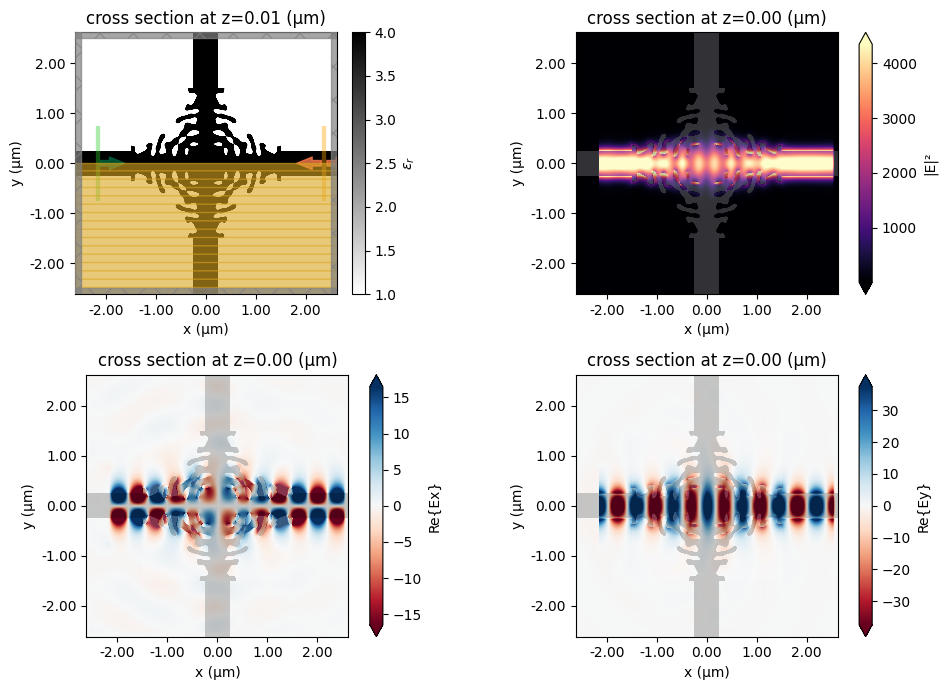

In [29]:
f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)
sim_final.plot_eps(z=0.01, ax=ax0)
ax1 = sim_data_final.plot_field("field", "E", "abs^2", z=0, ax=ax1)
ax2 = sim_data_final.plot_field("field", "Ex", z=0, ax=ax2)
ax3 = sim_data_final.plot_field("field", "Ey", z=0, ax=ax3)
plt.show()

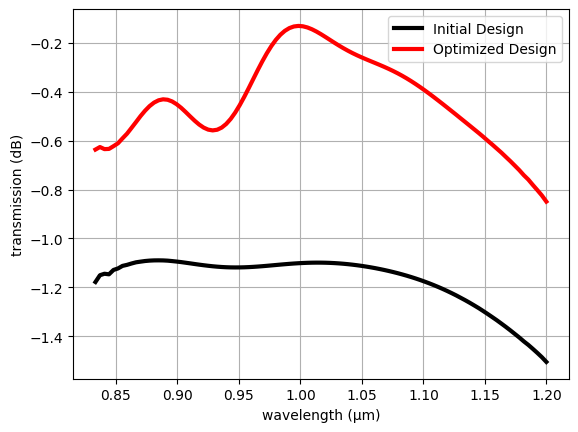

In [30]:
transmission_final = abs(sim_data_final["mode_multiple_wl"].amps.sel(direction="+")) ** 2
transmission_final_db = 10 * np.log10(transmission_final)

plt.plot(wavelengths, transmission_init_db, c="black", label="Initial Design", linewidth=3)
plt.plot(wavelengths, transmission_final_db, c="red", label="Optimized Design", linewidth=3)
plt.xlabel("wavelength (μm)")
plt.ylabel("transmission (dB)")
plt.legend()
plt.grid()
plt.show()

It seems to perform quite well! Let's export the simulation to a GDS file for fabrication!

In [31]:
# uncomment below to export

# sim_final.to_gds_file(
#     fname="./misc/invdes_crossing.gds",
#     z=0,
#     frequency=freq0,
#     permittivity_threshold=(eps_mat + 1) / 2.0
# )

## Other Examples

Here are some other selected inverse design examples if you want to explore more!

- [Mode converter](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd3InverseDesign.html)
- [Shape optimized taper](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd5BoundaryGradients.html)
- [Metalens optimization](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd7Metalens.html)
- [Wavelength division de-multiplexer](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Autograd9WDM.html)